In [1]:
import tensorflow as tf

In [2]:
import keras

In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=10,6
RANDOM_SEED=42
LABELS=['Normal','Fraud']

In [4]:
 #load the data
 df=pd.read_csv('creditcard.csv')
 df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

In [6]:
df.isnull().values.any()

False

In [7]:
df.isna().sum().sum()

0

Text(0, 0.5, 'Frequency')

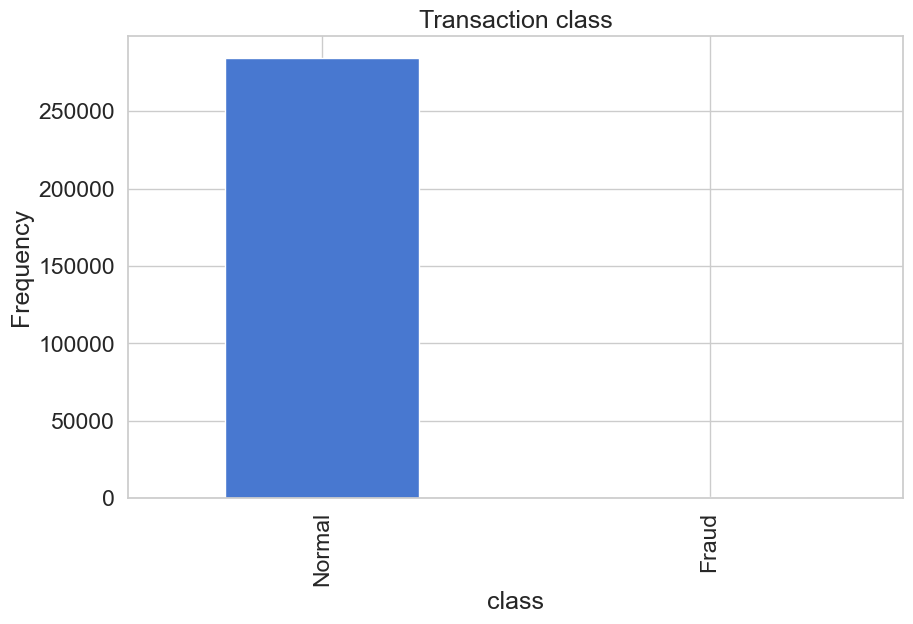

In [8]:
count_classes=pd.value_counts(df['Class'],sort=True)
count_classes.plot(kind='bar')
plt.title('Transaction class')
plt.xticks(range(2),LABELS)
plt.xlabel('class')
plt.ylabel('Frequency')

<Axes: ylabel='count'>

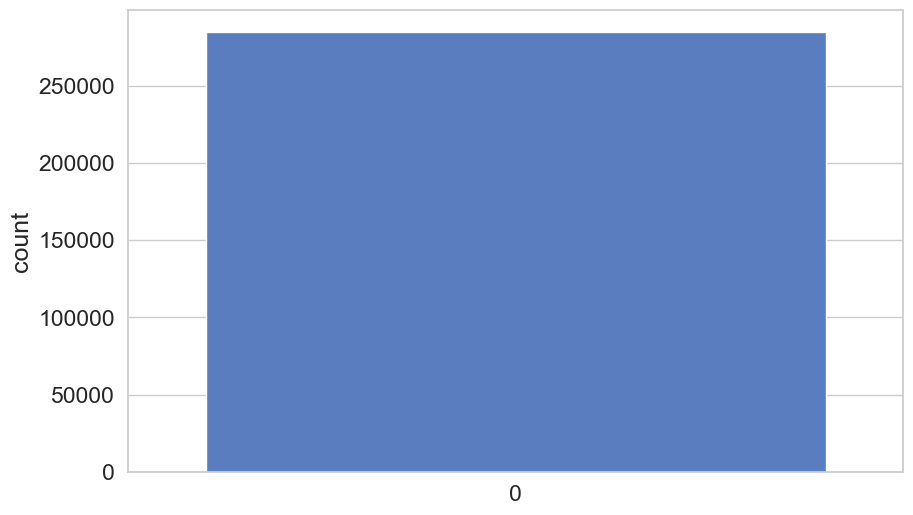

In [9]:
sns.countplot(df['Class'])

In [10]:
frauds=df[df.Class==1]
normal=df[df.Class==0]

In [11]:
frauds.shape

(492, 31)

In [12]:
normal.shape

(284315, 31)

In [13]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
 normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

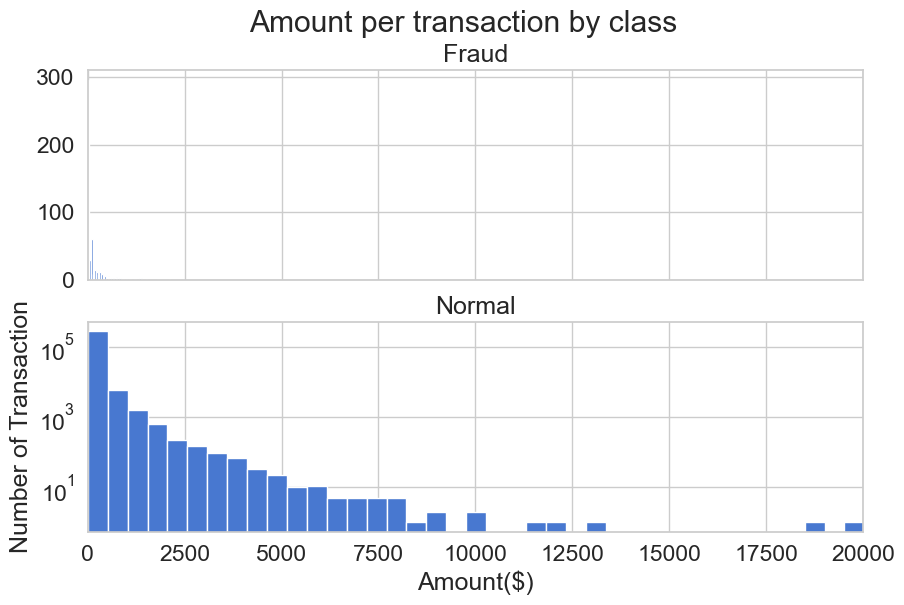

In [16]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(frauds.Amount,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount,bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount($)')
plt.ylabel('Number of Transaction')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

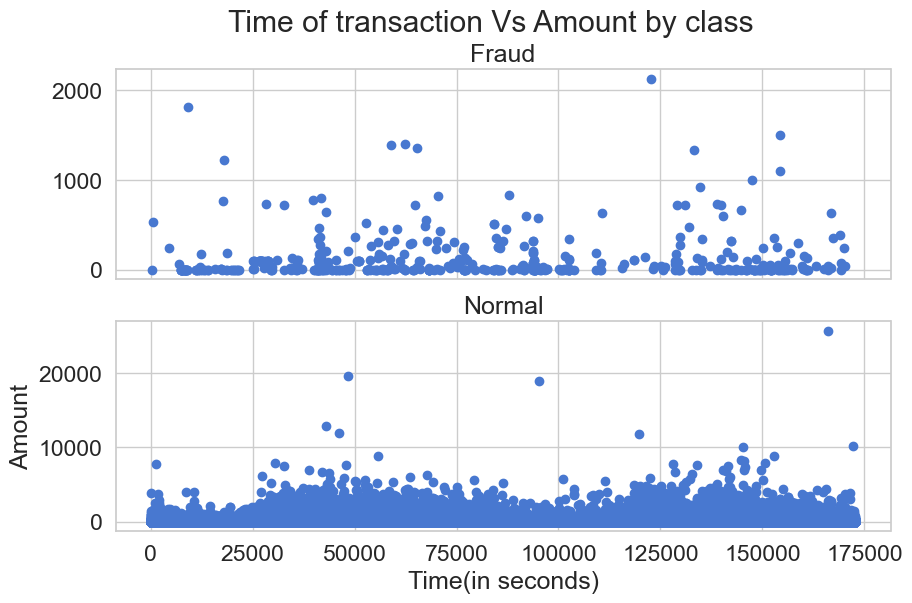

In [17]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction Vs Amount by class')
ax1.scatter(frauds.Time,frauds.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time(in seconds)')
plt.ylabel('Amount')
plt.show()

In [18]:
#Preparing the data

from sklearn.preprocessing import StandardScaler
data=df.drop(['Time'],axis=1)
data['Amount']=StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

In [19]:
data['Amount'][0]

0.24496426337017338

In [21]:
#Split the data for training Autoencoder

xtrain,xtest=train_test_split(data,test_size=0.2,random_state=RANDOM_SEED)
xtrain=xtrain[xtrain.Class==0]
xtrain=xtrain.drop(['Class'],axis=1)
print(xtrain.shape)
print()
#print(xtrain.head(2))

(227451, 29)



In [22]:
ytest=xtest['Class']
#xtest.head()       
xtest=xtest.drop(['Class'],axis=1)
xtrain=xtrain.values
xtest=xtest.values

In [23]:
print(xtrain.shape)
print()
print(xtest.shape)

(227451, 29)

(56962, 29)


In [ ]:
#Building Autoencoder Model

In [24]:
input_dim=xtrain.shape[1]
encoding_dim=14

In [25]:
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
             activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)

In [26]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 29)                232       
                                                                 
Total params: 813 (3.18 KB)
Trainable params: 813 (3.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
 #Train the Model

In [27]:
nb_epoch=30
batch_size=32
autoencoder.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
checkpointer=ModelCheckpoint(filepath='model_ae.h5',
verbose=0,
save_best_only=True)
tensorboard=TensorBoard(log_dir='./logs',
histogram_freq=0,
write_graph=True,
write_images=True)
history=autoencoder.fit(xtrain,xtrain,
epochs=nb_epoch,
batch_size=batch_size,
shuffle=True,
validation_data=(xtest,xtest),
verbose=1,
callbacks=[checkpointer,tensorboard]).history

Epoch 1/30
7108/7108 [==============================] - 18s 2ms/step - loss: 0.8138 - accuracy: 0.5883 - val_loss: 0.7990 - val_accuracy: 0.6458
Epoch 2/30
  54/7108 [..............................] - ETA: 13s - loss: 0.8108 - accuracy: 0.6447

E:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 16s 2ms/step - loss: 0.7602 - accuracy: 0.6557 - val_loss: 0.7839 - val_accuracy: 0.6632
Epoch 3/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7490 - accuracy: 0.6719 - val_loss: 0.7748 - val_accuracy: 0.6760
Epoch 4/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7419 - accuracy: 0.6862 - val_loss: 0.7618 - val_accuracy: 0.6978
Epoch 5/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7274 - accuracy: 0.7074 - val_loss: 0.7555 - val_accuracy: 0.7073
Epoch 6/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7213 - accuracy: 0.7084 - val_loss: 0.7520 - val_accuracy: 0.7092
Epoch 7/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7186 - accuracy: 0.7084 - val_loss: 0.7488 - val_accuracy: 0.7084
Epoch 8/30
7108/7108 [==============================] - 16s 2ms/step - loss: 0.7174 - accuracy: 0.7093 - val_loss: 0.7492 - val_accuracy: 0.7

In [28]:
from keras.models import load_model
autoencoder=load_model('model_ae.h5')

In [ ]:
#Evaluation

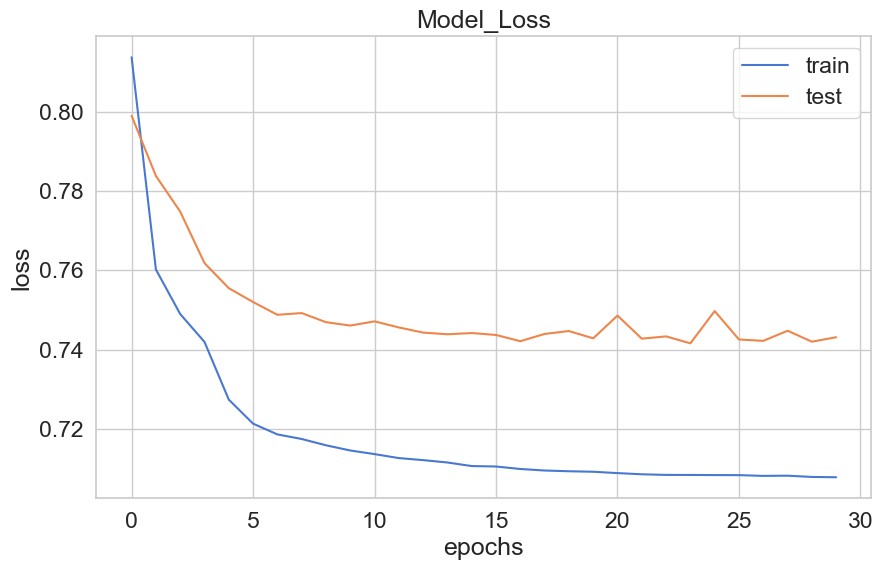

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper right')

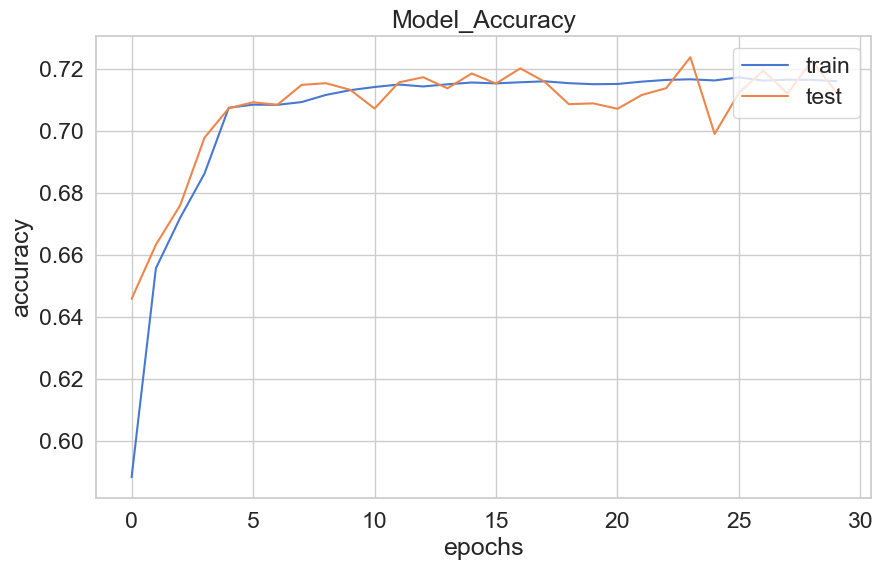

In [30]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper right')

In [31]:
predictions=autoencoder.predict(xtest)

1781/1781 [==============================] - 1s 723us/step


In [32]:
mse=np.mean(np.power(xtest-predictions,2),axis=1)
error_df=pd.DataFrame({'Reconstruction_error':mse,'true_class':ytest})

In [33]:
error_df

,Reconstruction_error,true_class
43428,82.611706,1
49906,0.852058,0
29474,0.231917,0
276481,0.410444,0
278846,0.181807,0
...,...,...
75723,0.724969,0
252263,0.206386,0
221246,0.523173,0
81910,0.127381,0


In [34]:
error_df.describe()

,Reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.740682,0.001720
std,3.366924,0.041443
min,0.040174,0.000000
25%,0.243299,0.000000
50%,0.385460,0.000000
75%,0.609624,0.000000
max,246.648584,1.000000
